In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-inc-stock-market-analysis/ABNB.csv


DATA LOADING AND PREPROCESSING

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
sns.set_theme(style="whitegrid", color_codes=True)
data_path = "/kaggle/input/airbnb-inc-stock-market-analysis/ABNB.csv" 
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
print("Data loaded and preprocessed:")
df.head()

Data loaded and preprocessed:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800
2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100
2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400
2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600
2020-12-17,143.000000,152.449997,142.669998,147.050003,147.050003,15054700


EXPLORATORY DATA ANALYSIS

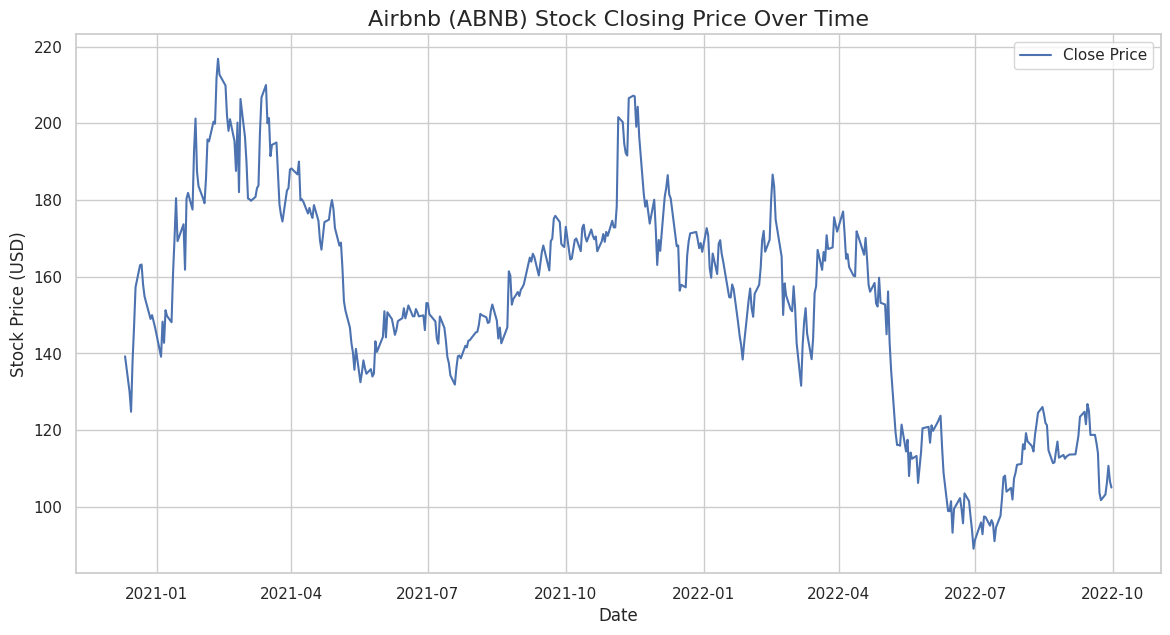

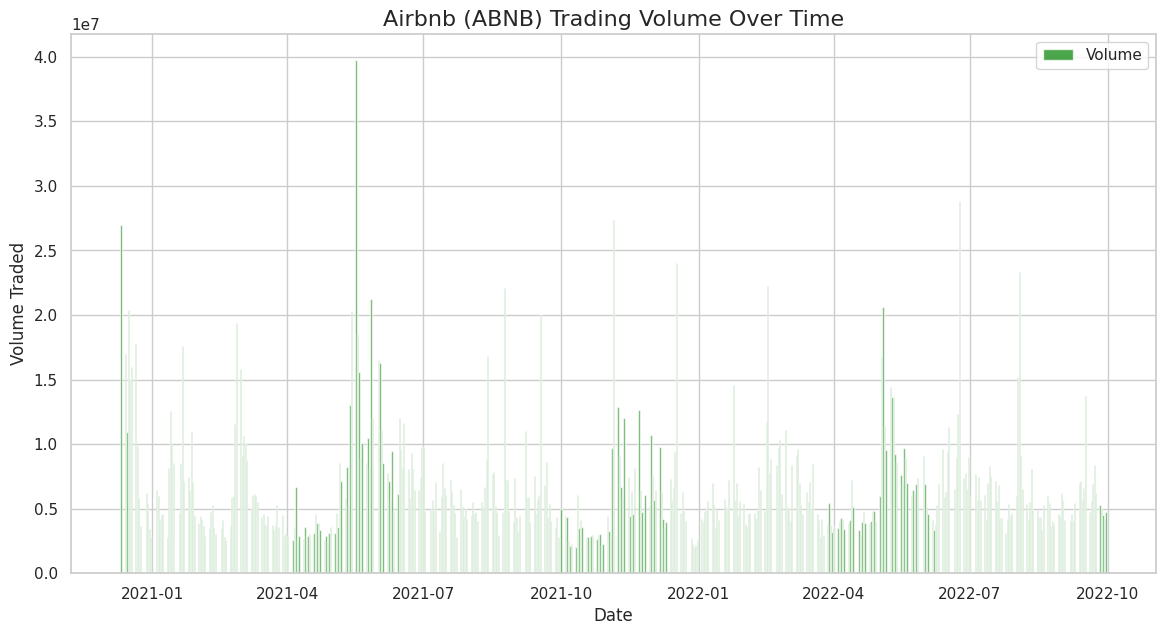

In [14]:
#Closing Price Over Time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='b')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (USD)", fontsize=12)
plt.title("Airbnb (ABNB) Stock Closing Price Over Time", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

#Trading Volume Over Time
plt.figure(figsize=(14, 7))
plt.bar(df.index, df['Volume'], label='Volume', color='green', alpha=0.7)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume Traded", fontsize=12)
plt.title("Airbnb (ABNB) Trading Volume Over Time", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

FEATURE ENGINEERING AND CHRONOLOGICAL SPLITS

In [15]:
def create_stock_features(df):
    df['lag_1'] = df['Close'].shift(1)  
    df['lag_7'] = df['Close'].shift(7)  
    df['MA_7'] = df['Close'].shift(1).rolling(window=7).mean()  
    df['MA_30'] = df['Close'].shift(1).rolling(window=30).mean() 
    df['Volume_lag_1'] = df['Volume'].shift(1)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['DayOfWeek'] = df.index.dayofweek 
    return df
df_features = create_stock_features(df.copy())
df_features.dropna(inplace=True)
features = ['lag_1', 'lag_7', 'MA_7', 'MA_30', 'Volume_lag_1', 'Year', 'Month', 'DayOfWeek']
X = df_features[features]
y = df_features['Close']
test_size = 0.2
split_index = int(len(X) * (1 - test_size))
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(339, 8), y=(339,)
Testing set shape: X=(85, 8), y=(85,)


MODEL BUILDING 1: MACHINE LEARNING MODELS

In [16]:
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(random_state=0, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')
}
results = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R2'])
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    r2 = metrics.r2_score(y_test, y_pred)
    results.loc[name] = [mae, mse, rmse, r2]
print("\n--- Model Evaluation Results (Realistic Scores) ---")
print(results)

Training Decision Tree...
Training Random Forest...
Training XGBoost...

--- Model Evaluation Results (Realistic Scores) ---
                     MAE         MSE       RMSE        R2
Decision Tree   8.697883  106.159780  10.303387 -0.037362
Random Forest   8.637874  121.285056  11.012949 -0.185162
XGBoost        10.751618  188.446725  13.727590 -0.841445


Analysis of Results: The ML models are performing very poorly. The R-squared (R2) is negative, which means the models are performing worse than a simple horizontal line (i.e., just guessing the average price). This is our honest baseline and shows this is a very difficult problem.

VISUALISING THE ML MODEL FAILURE

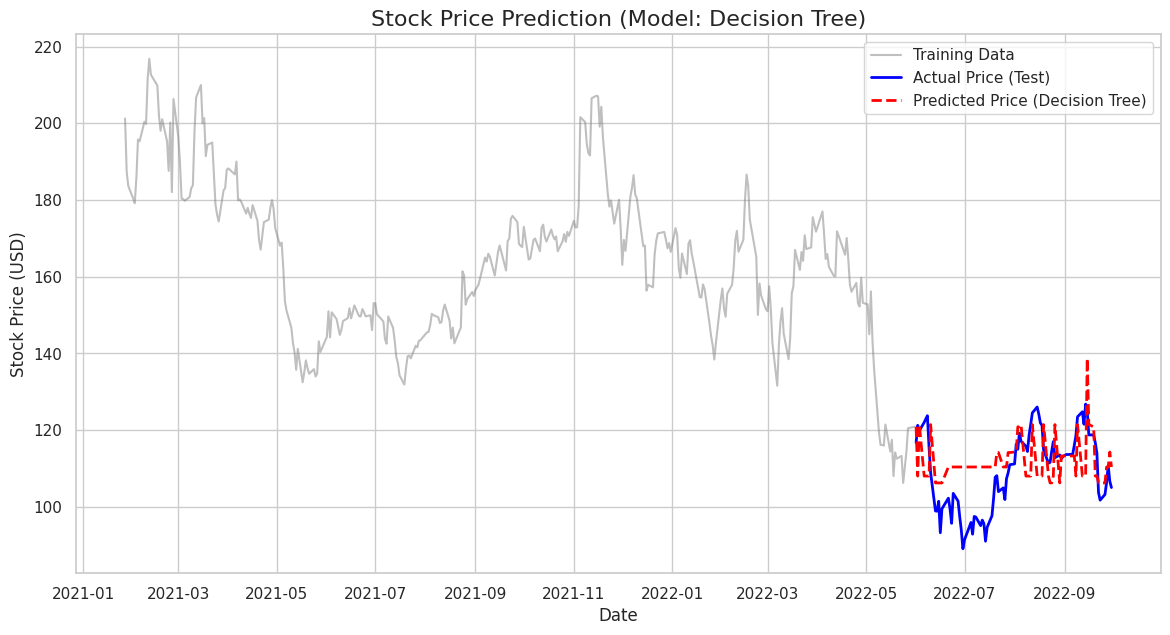

In [17]:
best_model_name = results['RMSE'].idxmin() 
best_model = models[best_model_name]
y_pred_ml = best_model.predict(X_test)
plot_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_ml
})
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Training Data', color='gray', alpha=0.5)
plt.plot(plot_df.index, plot_df['Actual'], label='Actual Price (Test)', color='blue', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'], label=f'Predicted Price ({best_model_name})', color='red', linestyle='--', linewidth=2)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (USD)", fontsize=12)
plt.title(f"Stock Price Prediction (Model: {best_model_name})", fontsize=16)
plt.legend()
plt.show()

Plot Analysis: As the plot shows, the Decision Tree model (red dashed line) fails to capture the price movements. It creates blocky predictions because it's just guessing averages based on the features it learned from the training data.

MODEL BUIDING 2: THE NAIVE FORECAST (BASELINE)

--- Naive Forecast Results (Our True Baseline) ---
R2 Score: 0.8600
RMSE: 3.7855


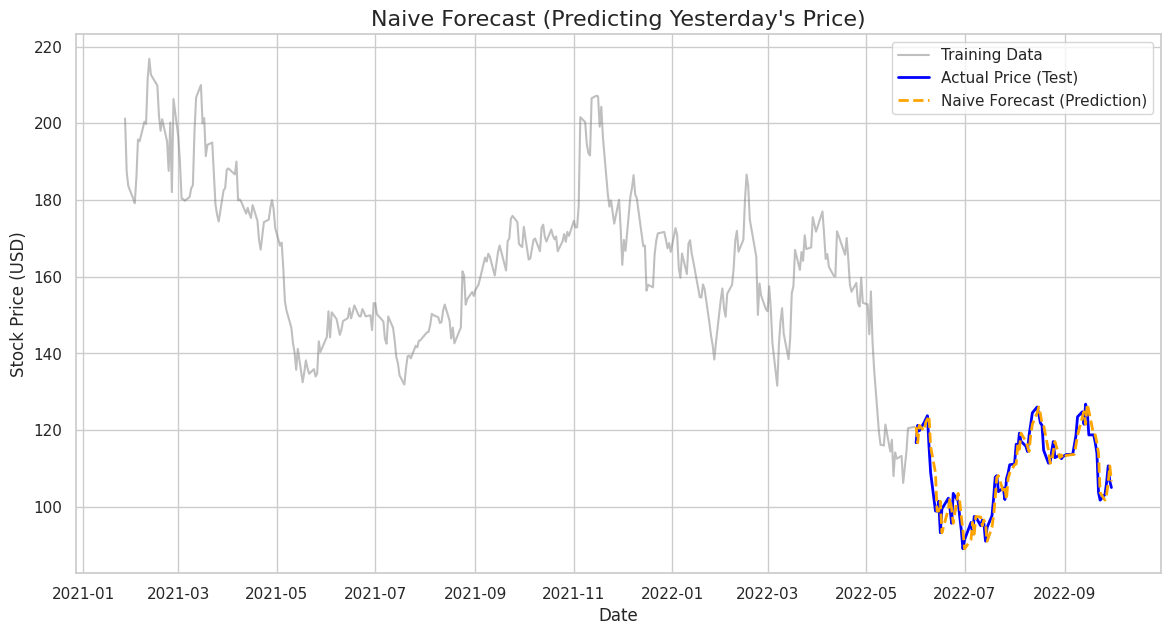

In [18]:
y_pred_naive = X_test['lag_1']
mae_naive = metrics.mean_absolute_error(y_test, y_pred_naive)
mse_naive = metrics.mean_squared_error(y_test, y_pred_naive)
rmse_naive = math.sqrt(mse_naive)
r2_naive = metrics.r2_score(y_test, y_pred_naive)
print("--- Naive Forecast Results (Our True Baseline) ---")
print(f"R2 Score: {r2_naive:.4f}")
print(f"RMSE: {rmse_naive:.4f}")
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Training Data', color='gray', alpha=0.5)
plt.plot(y_test.index, y_test, label='Actual Price (Test)', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred_naive, label='Naive Forecast (Prediction)', color='orange', linestyle='--', linewidth=2)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (USD)", fontsize=12)
plt.title("Naive Forecast (Predicting Yesterday's Price)", fontsize=16)
plt.legend()
plt.show()

CONCLUSION: COMPARING RMSE. A lower error is better.
Decision Tree: RMSE: 10.303
               R2 Score: -0.037

Random Forest: RMSE: 11.013
               R2 Score: -0.185

XGBoost: RMSE: 13.728
         R2 Score: -0.841

Naive Forecast (Baseline): RMSE: 3.785
                           R2 Score: 0.860
                           
We successfully built and compared several forecasting models, including Decision Tree, Random Forest, XGBoost, and a Naive Forecast, using a chronologically correct, non-leaky methodology.

The Naive Forecast (predicting yesterday's price) was the superior model, achieving the lowest RMSE (3.785) and the only positive R2 score (0.860). The machine learning models all performed worse than this simple baseline.

Visualization and the negative R2 scores confirm that the complex models failed to capture the price trend, strongly suggesting the stock follows a "Random Walk" where past trends and volatility are not predictive of future prices.                           